# Assignment 2: Model Creation with SciKit-learn

In this notebook, you will work through a series of exercises designed to deepen your understanding of model creation using SciKit-learn. The assignment requires code-based solutions—**manually computed or hard-coded results will not be accepted**. 

### Instructions:
- Write your solutions in the provided cells without altering or removing the test cells.
- Upon completion, submit the notebook in **.ipynb** format through Moodle.

In addition to the coding exercises, there are several open-ended questions that require thoughtful responses. Your answers should be thoroughly **justified** using: (a) Python code, (b) performance metrics, and (c) visualizations. Unsubstantiated responses will receive lower evaluations, so ensure your answers are supported with clear evidence.

In [1]:
# IMPORTANT: DO NOT MODIFY OR DELETE THIS CELL.
# Do not add any cells before this one.
# This cell must remain as the first cell in your notebook for proper functionality.


<div class="alert alert-warning">

The following cell contains two functions for result visualization. **DO NOT MODIFY** them.

You are allowed to reuse parts of this code for the open-ended questions,  but ensure both functions remain unchanged in their original form.

- The `plot_decision_surface` function generates a scatter plot of the training data (as circles) and test data (as diamonds), along with the model's decision boundary.
  
- The `plot_parallel_coordinates` function visualizes the accuracy, precision, recall, and F1-score in relation to the gamma parameter of a Support Vector Machine classifier.
</div>

In [2]:
# IMPORTANT: DO NOT MODIFY OR DELETE THIS CELL.
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import set_config
import plotly.graph_objects as go

set_config(transform_output="pandas")

def plot_decision_surface(X_train, y_train, X_test=None, y_test=None, model=None, show_points=True, title=None):
    if X_train.shape[1] != 2:
        raise ValueError(f'Incorrect shape {X.shape}, can only plot 2D datasets')

    # just plot the dataset first
    cm = 'coolwarm'
    cm_bright = ListedColormap(['#0000FF', '#FF0000', ])

    fig, ax = plt.subplots()

    if model is not None:
        x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
        y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                             np.arange(y_min, y_max, 0.01))
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        X_mesh = np.c_[xx.ravel(), yy.ravel()]
        try:
            Z = model.decision_function(X_mesh)
        except AttributeError:
            try:
                Z = model.predict_proba(X_mesh)[:, 1]
                if Z.min() >= 0:
                    Z = Z * 2 - 1
            except AttributeError:
                Z = model.predict(X_mesh)
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        Z_max = np.abs(Z).max()
        cs_contourf = ax.contourf(xx, yy, Z, levels=10, cmap=cm, alpha=.8, vmin=-Z_max, vmax=Z_max, )
        cs_contour = ax.contour(xx, yy, Z, [-1, 0, 1], linewidths=[1, 2, 1], alpha=0.5,
                                colors=('#0000FF', 'gray', '#FF0000'))

        # Make a colorbar for the ContourSet returned by the contourf call.
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)

        cbar = ax.figure.colorbar(cs_contourf, cax=cax)
        # Add the contour line levels to the colorbar
        try:
            cbar.add_lines(cs_contour)
        except Exception:
            pass
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())

    if show_points:
        # # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   #edgecolors='k', 
                   alpha=0.25)
        # ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
        #                edgecolors='k', alpha=0.6, s=140)
        if X_test is not None:
            # and testing points
            ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                       #edgecolors='k',
                       # s=100,
                       marker='D')

    ax.set_xticks(())
    ax.set_yticks(())

    ax.set_aspect('equal', 'box')
    if title is not None:
        ax.set_title(title)
    plt.show()


def plot_parallel_coordinates(df, svm_models, title):
    df = df.copy()
    with pd.option_context('future.no_silent_downcasting', True):
        df = df.replace({'gamma': {'scale': svm_models['scale']._gamma}})
    dimensions = [
        dict(range=[0, 1],
             label='Accuracy', values=df['accuracy']),
        dict(range=[0, df['gamma'].max()],
             label='Gamma', values=df['gamma']),
        dict(range=[0, 1],
             label='Precision 0', values=df['precision_class_0']),
        dict(range=[0, 1],
             label='Precision 1', values=df['precision_class_1']),
        dict(range=[0, 1],
             label='Recall 0', values=df['recall_class_0']),
        dict(range=[0, 1],
             label='Recall 1', values=df['recall_class_1']),
        dict(range=[0, 1],
             label='F1 0', values=df['f1_class_0']),
        dict(range=[0, 1],
             label='F1 1', values=df['f1_class_1'])
    ]
    if 'dataset_size' in df.columns:
        dimensions.insert(1, dict(range=[0, 2500],
                                   label='Dataset size', values=df['dataset_size'],
                                   tickvals=[250, 2500],
                                   ticktext=['250', '2500']))

    
    fig = go.Figure(
        go.Parcoords(
            line=dict(color=df.index.to_list(), colorscale='Plasma_r', showscale=False),
            dimensions=dimensions
        ))
    fig.update_layout(
        title=title,
        font_size=10
    )
    fig.show()


<div class="alert alert-info"><b>Exercise 1: Synthetic dataset generation</b>

Write code to generate the feature matrix `X` and the target array `y` using the `make_moons` function from the `sklearn.datasets` module with the parameters: `n_samples=250`, `noise=0.1`, and `random_state=42`. After creating the dataset, call `plot_decision_surface(X, y)` to visualize the data distribution.

<br><i>[0.5 points]</i>
</div>
<div class="alert alert-warning">

Python is case-sensitive, so ensure your code matches the required capitalization.

</div>

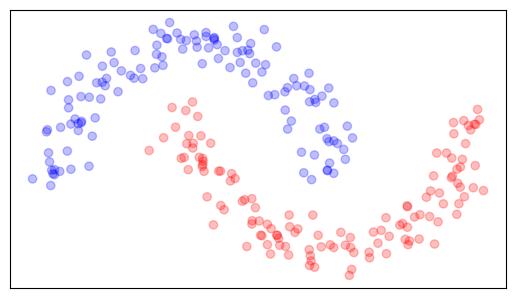

In [3]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=250, noise=0.1, random_state=42)

plot_decision_surface(X, y)

In [4]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 1: Train-test split </b>

Write code to split the generated dataset into training and testing sets, allocating 80% of the data for training and 20% for testing. Use `random_state=42` to ensure reproducibility. Store the resulting arrays in `X_train`, `X_test`, `y_train`, and `y_test`. After creating the dataset, call again `plot_decision_surface(X_train, y_train, X_test, y_test)` to visualize the train and test data distribution.
<br><i>[0.25 points]</i>
</div>

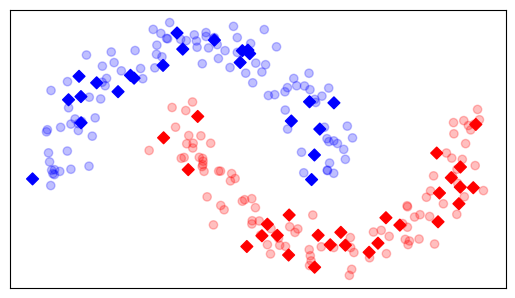

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plot_decision_surface(X_train, y_train, X_test, y_test)

In [6]:
# LEAVE BLANK

In [7]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 2: Logistic regression model creation</b>

Write code to fit a logistic regression model to the training data and store the model in a variable called `logistic`. Then, calculate the accuracy for both the training and testing sets, and store the results in `train_accuracy` and `test_accuracy`, respectively.

<br><i>[0.5 points]</i>
</div>


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logistic = LogisticRegression(random_state=42)
logistic.fit(X_train, y_train)

y_train_pred = logistic.predict(X_train)
y_test_pred = logistic.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(train_accuracy)
print(test_accuracy)

0.855
0.9


In [9]:
# LEAVE BLANK

In [10]:
# LEAVE BLANK

In [11]:
# LEAVE BLANK

In [12]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 3: Explain logistic regression decision boundary</b>

Provide substantiated answers to the following questions:

- What issues, if any, do you observe in the model’s performance or behavior? Is the decision boundary well-suited to the underlying structure of the data?
- Are there specific areas where the model underperforms? If so, do you believe accuracy alone is an adequate metric to evaluate the model’s performance?
- Do you think logistic regression is an appropriate model for this dataset? Why or why not?
- Does the model appear to overfit or underfit the data? What evidence supports your conclusion?

<br><i>[0.5 points]</i>
</div>

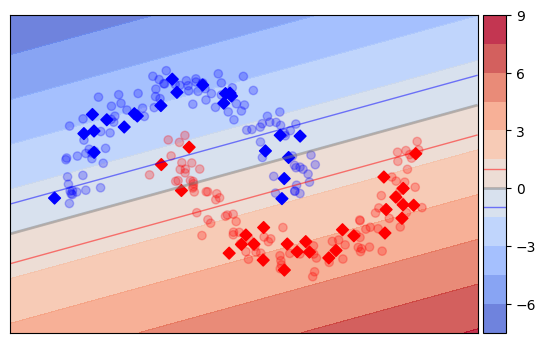

In [13]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_decision_surface(X_train, y_train, X_test, y_test, logistic)

1. The dataset is not linear, which means that the linear decision boundary observed here is not suitable. The performance of the model's prediction will not be good, because it can not represent the non-linear behaviour of the data.

2. Where the red and blue data classes intertwine with each other, the model underperforms heavily in trying to predict the class. Thus, I believe that accuracy alone is not an adequate measure of a model's performance. Rather additional metrics, such as recall, precision and f1, could be taken into account.

3. Logistic Regression is not an appropriate model for this dataset, as it is a linear model and the dataset has complex non-linear data points.

4. The model appears to be underfitting the data, as it is not able to capture the complex shape of the data. This leads to a lot of data being misclassified.

<div class="alert alert-info"><b>Exercise 4: Decision tree model creation</b>

Write code to fit a decision tree classifier to the training data and store the model in a variable named `dt`. Next, compute the accuracy, precision, and recall for both the training and testing sets, and store the results in the following variables: `train_accuracy`, `train_precision`, `train_recall`, `test_accuracy`, `test_precision`, and `test_recall`.

<br><i>[0.5 points]</i>
</div>

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print(train_accuracy)
print(train_precision)
print(train_recall)
print(test_accuracy)
print(test_precision)
print(test_recall)

1.0
1.0
1.0
0.98
0.9642857142857143
1.0


In [15]:
# LEAVE BLANK

In [16]:
# LEAVE BLANK

In [17]:
# LEAVE BLANK

In [18]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 5: Explain the decision tree classifier decision boundary</b>

Provide well-supported answers to the following questions:

- Why is the decision tree model a good fit for this dataset?
- Why is the decision boundary of the decision tree seems a heavyside step function? Does this structure contribute to overfitting or underfitting, and can you observe these issues in specific regions of the data?
- How do the decision boundaries produced by decision trees differ from those of logistic regression, particularly when dealing with nonlinear patterns?
- What are the strengths and weaknesses of decision trees compared to logistic regression?

<br><i>[0.75 points]</i>
</div>

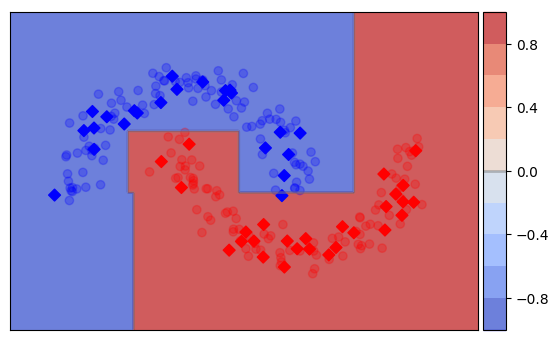

In [19]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_decision_surface(X_train, y_train, X_test, y_test, dt)

1. The decision tree model is capable of adapting to non-linear datasets.

2. With a decision tree model, the boundary is created in rectangles and classified using thresholds of the data contained within these regions to split the axis. Therefore, overfitting is a common problem of the model, as noise can easily be captured by accurately following the data distribution. For instance, this can be seen on the leftmost border of the red area, where a small encroachment on the blue area can be seen.

3. In contrast to logistic regression, decision tree boundaries are non-linear, enabling them to capture more complex datasets accurately. The result of this is that the decision tree model appears in stepped blocks, while the logistic regression appears linear.

4. The strengths of the decision tree model are its flexibility, ease of interpretation and independence of feature scaling, while the weaknesses are its tendency to overfitting and instability. The strengths of the logistic regression model are its simplicity, ease of interpretation and general applicability, while the weaknesses are its inadequacy for non-linear datasets and need for feature scaling.

<div class="alert alert-info"><b>Exercise 6: Support vector machine model creation </b>

Write code to fit a Support Vector Machine (SVM) classifier with an RBF kernel to the training data and store the model in a variable named `svm`. Then, calculate the accuracy, precision, recall, and F1-score for both the training and testing sets, storing the results in the following variables: `train_accuracy`, `train_precision`, `train_recall`, `test_accuracy`, `test_precision`, `test_recall`, and `test_f1`.

<br><i>[0.5 points]</i>
</div>


In [20]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score

svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train, y_train)

y_train_pred = svm.predict(X_train)
y_test_pred = svm.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(train_accuracy)
print(train_precision)
print(train_recall)
print(train_f1)
print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [21]:
# LEAVE BLANK

In [22]:
# LEAVE BLANK

In [23]:
# LEAVE BLANK

In [24]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 7: Explain the  support vector machine model decision boundary</b>

Provide well-reasoned answers to the following questions:

- Why is the SVM a good fit for this dataset?
- How do support vectors determine the decision boundary, and what impact does this have on the model's effectiveness?
- Why does the SVM produce a smooth, continuous decision boundary, unlike the 'blocky' boundaries seen in decision trees?
- How do the decision boundaries of SVM differ from the linear boundaries of logistic regression?
- What are the strengths and weaknesses of SVM compared to logistic regression and decision trees?
- In what scenarios might logistic regression be more suitable, and when would SVM be a better choice?
- How do support vectors shape the SVM's decision boundary, and how does this differ from the recursive partitioning method used by decision trees?

<br><i>[1 points]</i>
</div>

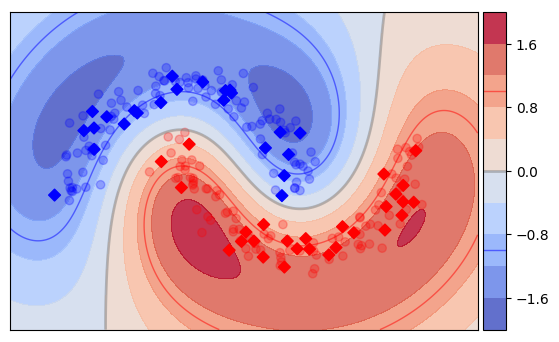

In [25]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_decision_surface(X_train, y_train, X_test, y_test, svm)

1. As the dataset is non-linear, the model has to be able to capture this, which the SVM with RBF kernel is capable of.

2. Support vectors are the data points closest to the decision boundary, which means they have a strong impact on the positioning of the boundary. This make the SVM very effective in creating robust decision boundaries.

3. The SVM with RBF kernel maps the features into a higher dimensional space, making it able to more accurately separate the classes. In contrast, the Decision Tree model appears 'blocky' because it uses recursive partitioning to split the feature space into rectangular segments.

4. The decision boundaries of the SVM model with RBF are curved and can thus better capture the non-linear nature of the dataset, unlike the Logistic model which can only generate linear boundaries and thus is not able to accurately represent the data.

5. The strengths of SVM models are that they are highly accurate for non-linear models, robust against outliers and effective in high dimensional spaces. However, they are more complex in computing and refining its parameters. Compared to Logistic models, it sacrifices simplicity for complexity in terms of output and training. Compared to Decision Tree models, it can create smoother boundaries while reducing overfitting but is again more training intensive.

6. In scenarios where the data points in the set follow a linear distribution and simplicity and interpretability are key, it's better to use Logistic Regression. For when the data is non-linear, the size of the dataset isn't too large and accuracy is important, SVM is chosen.

7. The SVM model maximizes the margin around the decision boundary, which is only influenced by the support vectors, resulting in a curvy boundary. On the other hand, in Decision Tree models the boundaries are created using axis-aligned segments, resulting in blocky boundaries. This means that Decision Tree models are iteratively identifying their classification while SVM models estimate a global solution maximizing the margin.

<div class="alert alert-info"><b>Exercise 8: Generating a Noisy Dataset</b>

The dataset used in the previous exercies had an easy and well-defined decision boundary. However, real business datasets contains noise and errors, making the classification task more complex and intrincate. To generate a more realistic dataset, write code to generate a new feature matrix `X` and a target array `y` using the `make_moons` function with the parameters: `n_samples=250`, `noise=0.4`, and `random_state=42`. Then, split the generated dataset into training and testing sets, allocating 80% of the data for training and 20% for testing. Use `random_state=42` to ensure reproducibility. Store the resulting arrays in `X_train`, `X_test`, `y_train`, and `y_test`. Finally, call again `plot_decision_surface(X_train, y_train, X_test, y_test)` to visualize the new train and test data distribution.

<br><i>[0.25 points]</i>
</div>

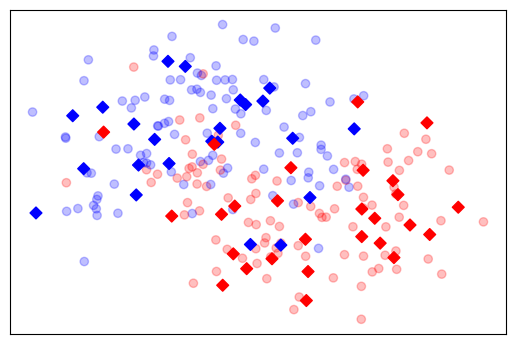

In [26]:
X, y = make_moons(n_samples=250, noise=0.4, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plot_decision_surface(X_train, y_train, X_test, y_test)

In [27]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 9: Analyzing the potential negative impact of noisy datasets</b>

Provide well-supported answers to the following questions:

- How do you think increased noise in the dataset will impact model performance? Which model do you expect to handle noise best, and why?
- How might the logistic regression model be affected by noisy data?
- How do you think noise will influence the decision tree model? Will the step-like characteristic of the boundaries of decision trees become more irregular or over-complicated due to noise? How might this affect performance, especially on unseen data?
- How will the SVM's decision boundary be influenced by noisy data? Do you expect SVM to become more sensitive to noisy data points near the boundary? How might this impact the margin, support vectors, and lead to overfitting or a reduction in margin width?
- What strategies can be used to mitigate the effects of noise on these models?

<br><i>[0.75 points]</i>
</div>

1. As noise increases, the performance of the model will deteriorate, because the data will include more outliers, which can lead the model to overfit or underfit. SVM will handle noise the best, due to its support vectors defining the boundary and maximizing the margin between classes, making it less susceptible to distant points not significantly influencing the margin.

2. Because the Logistic Regression has simple linear decision boundaries, it's less prone to being influenced by noisy datapoints (overfitting). However, noise will still decrease the model performance by including misrepresenting data points in its coefficients.

3. The Decision Tree model tends to overfit with increased noise, as it tries to comply with more distant points. As a result, the 'blocky' characteristics will only increase with irregular and fragmented boundaries due to noise. The performance of the model will decrease, because you can not generalize a pattern from the data which is applicable to unseen data.

4. Compared to the other options, SVM is relatively robust against noise, because it uses support vectors and margins to form the decision boundary. However, if there's a lot noise near the decision boundary, it can be mistaken for support vectors and thus influence and decrease the boundary margin, pushing the boundary outwards and leading to overfitting.

5. First of all, outliers in the data can be removed with proper preprocessing. Additionally, they can be removed by using k-fold cross-validation to filter out the non-core data points through training and testing on data subsets. Random Forests can also help reduce sensitivity to noise by averaging the predictions. Lastly, there can be techniques implemented within the models, such as regularization for Logistic Regression, pruning for Decision Tree and changing the kernel for SVM.

<div class="alert alert-info"><b>Exercise 10: Adding a regularization term</b>

Now, it's time to explore the impact of hyperparameters on model performance. To understand the role of the `gamma` hyperparameter in SVM models, refer to [this resource](https://amagash.github.io/pages/exploration/supervised-learning/svm.html). Additionally, for a general understanding of regularization in supervised learning and SVMs in particular, check out these links: [Simplilearn's guide on regularization](https://www.simplilearn.com/tutorials/machine-learning-tutorial/regularization-in-machine-learning) and [Wikipedia's overview](https://en.wikipedia.org/wiki/Regularization_perspectives_on_support_vector_machines).

Your task is to write a function called `get_metrics(model, X, y)`, where the first parameter is a pre-trained model, `X` is the feature matrix, and `y` is the target array. This function should return a dictionary containing key-value pairs for the following metrics: accuracy, precision for class 0 and class 1, recall for class 0 and class 1, and F1-score for class 0 and class 1. The dictionary should be structured as follows:

```python
{
   'accuracy': accuracy, 
   'precision_class_0': precision_class_0, 
   'precision_class_1': precision_class_1, 
   'recall_class_0': recall_class_0, 
   'recall_class_1': recall_class_1, 
   'f1_class_0': f1_class_0, 
   'f1_class_1': f1_class_1
}
```

Next, train three SVM models using the following values for the `gamma` parameter: `0.01`, `'scale'`, and `100`, while keeping the other hyperparameters at their default values. Store these models in a dictionary called `svm_models`, where each key is the corresponding `gamma` value and the value is the trained model. Use the function `get_metrics(model, X, y)` to generate two DataFrames `train_metrics`, and `test_metrics` to store performance metrics and its corresponding `gamma` value. Finally, find the model with the highest accuracy and store it in a variable called `best_svm`.

<br><i>[1 points]</i>
</div>

In [28]:
import pandas as pd

def get_metrics(model, X, y):
    y_pred = model.predict(X)
    metrics = {
        'accuracy': accuracy_score(y, y_pred),
        'precision_class_0': precision_score(y, y_pred, pos_label=0),
        'precision_class_1': precision_score(y, y_pred, pos_label=1),
        'recall_class_0': recall_score(y, y_pred, pos_label=0),
        'recall_class_1': recall_score(y, y_pred, pos_label=1),
        'f1_class_0': f1_score(y, y_pred, pos_label=0),
        'f1_class_1': f1_score(y, y_pred, pos_label=1)
    }
    return metrics


svm_models = {}
gamma_parameters = [0.01, 'scale', 100]

for gamma in gamma_parameters:
    svm_gamma = SVC(gamma=gamma, random_state=42)
    svm_gamma.fit(X_train, y_train)
    svm_models[gamma] = svm_gamma


train_metrics = pd.DataFrame([get_metrics(model, X_train, y_train) for model in svm_models.values()])
test_metrics = pd.DataFrame([get_metrics(model, X_test, y_test) for model in svm_models.values()])

train_metrics['gamma'] = gamma_parameters
test_metrics['gamma'] = gamma_parameters


best_svm = svm_models[test_metrics.loc[test_metrics['accuracy'].idxmax(), 'gamma']]
best_svm_accuracy = test_metrics.loc[test_metrics['accuracy'].idxmax(), 'accuracy']
best_svm_gamma = test_metrics.loc[test_metrics['accuracy'].idxmax(), 'gamma']


print(f'The best SVM Model {best_svm} has an accuracy of {best_svm_accuracy} with gamma "{best_svm_gamma}"')

The best SVM Model SVC(random_state=42) has an accuracy of 0.86 with gamma "scale"


In [29]:
# LEAVE BLANK

In [30]:
# LEAVE BLANK

In [31]:
# LEAVE BLANK

In [32]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 11: Explain SVM regularization effect</b>

Provide well-reasoned answers to the following questions:

- How does adjusting the `gamma` parameter impact the model’s complexity? Which values of `gamma` produce a smoother, more generalized decision boundary, and how does this affect the model's ability to handle noise? Conversely, which values result in a more complex decision boundary that may overfit the data, including noise?
- Can you pinpoint regions where overfitting or underfitting occurs based on the different `gamma` values?
- How do precision and recall vary as you change the `gamma` parameter? Does a higher `gamma` lead to better precision at the expense of recall, or the opposite?
- How do the test set metrics compare to the training set metrics for different `gamma` values? 
- Based on these observations, which model would you select, and why?
- What modifications could be made to improve the chosen model's performance on the noisy dataset?

<br><i>[1 points]</i>
</div>

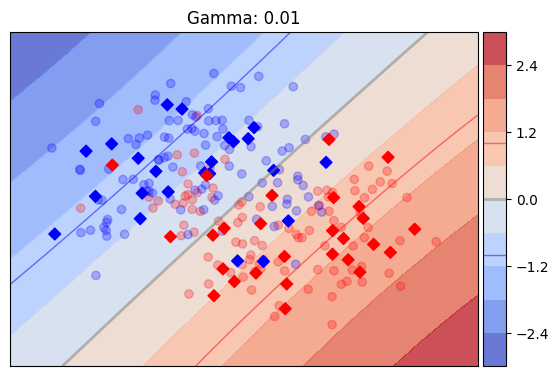

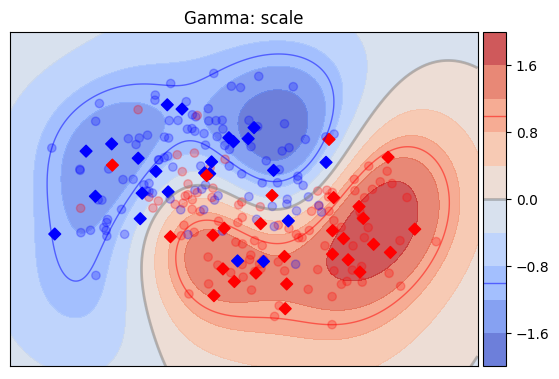

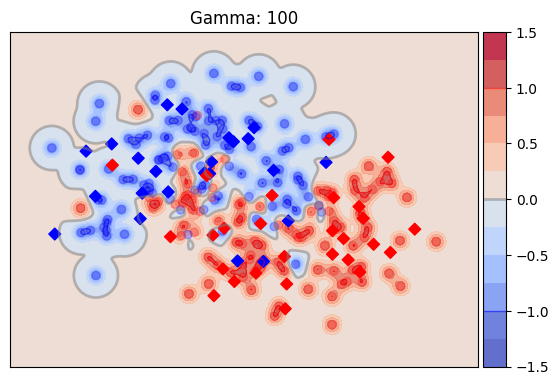

In [33]:
# DO NOT MODIFY THIS CELL. Simply execute it.
for svm in svm_models.values():
    plot_decision_surface(X_train, y_train, X_test, y_test, svm, title=f'Gamma: {svm.gamma}')

In [34]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_parallel_coordinates(train_metrics, svm_models, 'Train metrics')
plot_parallel_coordinates(test_metrics, svm_models, 'Test metrics')

1. In the models of this exercise, the higher the gamma value is, the greater the complexity is. Low gamma values, such as 0.01, produce a smoother and more general descicion boundary. These types of boundaries handle noise better but if the data is too broad can result in underfitting. On the other hand a high gamma value like 100 can lead to a more complex boundary but risks overfitting.

2. Where gamma value is lowest (0.01), underfitting occurs leading to many misclassifications of test data, especially of red data in the upper left region and vice versa. Where gamma value is 'scale', there are still a few misclassified data points, again in the same but smaller regions, due to its curvature. Where gamma is highest (100), overfitting is more likely to occur as the model captures more detailed patterns making it perform very well on the traning data but less accurately on new test data in the same regions as before.

3. In general, lower gamma values may improve recall by capturing more of the positive class but can lead to lower precision due to a more incocise and broad boundary. In contrast, higher gamma values increase precision by focusing on accurately classifying the positive class but may reduce recall as it sacrifices some true positives to achieve specificity.

4. For the lowest gamma value, train and test sets differ slightly but are not very high, indicating underfitting. The 'scale' gamma metrics are quite similar between train and test and higher than the lowest gamma metrics. With the highest gamma value, the metrics for train and test sets differ heavily, with almost achieving perfect metrics for training but significantly lower metrics for testing, also compared to the other gamma values, indicating overfitting.

5. Based on the previously described observations, the values for the lowest gamma value indicate underfitting, while the values for the highest gamma value indicate overfitting. Therefore, we would choose the 'scale' model, as it delivers the most reliable train and test metrics, especially precision and recall, meaning it has good generalization without being disturbed by the noise too much.

6. To improve the 'scale' model in handling the noise, we can preprocess the data to reduce the number of noisy data points. We can also use corss-validation to train the model on multiple iterations and thus ensure the model generalizes among mostly relevant data points and excludes random noise.

<div class="alert alert-info"><b>Exercise 12: Increase size of dataset</b>

Now, let's retrain the least regularized SVM model with `gamma` set to 100, but this time using a larger dataset. Generate the dataset using the `make_moons` function with the parameters: `n_samples=2500`, `noise=0.4`, and `random_state=42`. Next, split the dataset into training and testing sets, with 80% of the data for training and 20% for testing, ensuring reproducibility by using `random_state=42`. Store the resulting arrays as `X_train`, `X_test`, `y_train`, and `y_test`.

Fit the SVM model using the training data and store it in a variable called `non_regularized_svm`. Then, use the `get_metrics` function to compute the performance metrics, as done in the previous exercise, and append the results to the `train_metrics` and `test_metrics` dataframes.

Finally, add a new column named `dataset_size` to the metrics dataframes, assigning a value of `2500` for the new `non_regularized_svm` model and `250` for the previous models.

<br><i>[1 points]</i>
</div>

In [35]:
X, y = make_moons(n_samples=2500, noise=0.4, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


non_regularized_svm = SVC(gamma=100, random_state=42)
non_regularized_svm.fit(X_train, y_train)

new_train_metrics = get_metrics(non_regularized_svm, X_train, y_train)
new_test_metrics = get_metrics(non_regularized_svm, X_test, y_test)

new_train_metrics_df = pd.DataFrame([{**new_train_metrics, 'gamma': 100, 'dataset_size': 2500}])
new_test_metrics_df = pd.DataFrame([{**new_test_metrics, 'gamma': 100, 'dataset_size': 2500}])

train_metrics = pd.concat([train_metrics, new_train_metrics_df], ignore_index=False)
test_metrics = pd.concat([test_metrics, new_test_metrics_df], ignore_index=False)

train_metrics['dataset_size'] = train_metrics['dataset_size'].fillna(250)
test_metrics['dataset_size'] = test_metrics['dataset_size'].fillna(250)

In [36]:
# LEAVE BLANK

In [37]:
# LEAVE BLANK


In [38]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 13: Explain size of dataset</b>

Provide well-reasoned answers to the following questions:

- How does increasing the dataset size help to reduce overfitting and improve the model’s test performance?
- As more data is added, how does the SVM's decision boundary become smoother, allowing the model to generalize better and avoid fitting to noise?
- How do the test metrics (such as accuracy, precision, and recall) improve in relation to the training metrics as the dataset size grows?
- Is there a point where adding more data stops providing significant improvements in performance?
- Why does increasing the dataset size help counterbalance the high `gamma` value, thereby reducing overfitting?
- How does the increase in data help the model create a smoother decision boundary?
- Would you still consider lowering the `gamma` value, or is increasing the dataset size sufficient to address overfitting in this case?
- In which situations might increasing the dataset size alone not be enough to mitigate overfitting, and how could adjusting the `gamma` parameter help in such cases?
- After evaluating the effect of dataset size on overfitting, which model would you choose? Do you believe that increasing the dataset size sufficiently improves the performance of the high-`gamma` model, or would a lower-`gamma` model perform better for this dataset?"

  

<br><i>[1 points]</i>
</div>
<div class="alert alert-warning">

The `plot_decision_surface` function may take up to 30 seconds to complete. Please be patient, this is expected behavior.

</div>


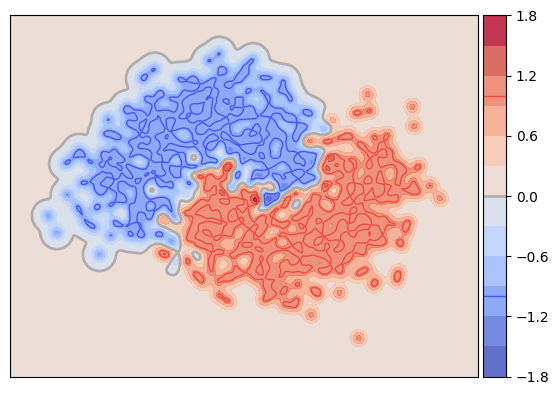

In [39]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_decision_surface(X_train, y_train, X_test, y_test, non_regularized_svm, show_points=False)

In [40]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_parallel_coordinates(train_metrics, svm_models, 'Train metrics')
plot_parallel_coordinates(test_metrics, svm_models, 'Test metrics')

1. When the size of the dataset is increased the model is able to learn more generalized patterns and it can detect more effectively irrelevant data points. As a result of this the boundaries and the model's test performance are improved.

2. As more data is added, there are more support vectors to help find a better decision boundary for the model and reducing the influence of noise, thereby making it better at generalization resulting in better performance on unseen data.

3. When the quantity of data grows, the test metrics of the model become more stable, meaning that test metrics get closer to the training metrics and the results are higher.

4. Yes, there is a point where adding more data yields diminishing returns (marginal utility), as the model's performance stabilizes once it sufficiently captures the underlying data patterns. This is usually the case when the training and test data converge and only have a minor difference.

5. As we explained in exercise 11, a high gamma value causes the model to make a more complex decision boundary by trying to fit every data point. With a larger dataset, the model is able to find more general patterns and vector supported boundaries, allowing it to balance the high sensitivity of the high gamma and reducing overfitting by not needing to rely on random data points.

6. Increasing the quantity of data gives the model more data points near the boundary and reducing influence by outliers, enabling it to form a smoother and more generalized boundary following the overall pattern more accurately.

7. As can be seen in the graphs, if the dataset is big enough it may aufficiently address overfitting caused by a high gamma resulting in metrics close to lower gamma models. However, lowering the gamma value might still be beneficial, as it can provide a more generalized model without the need for acquiring more data.

8. There exist situations where an increase in the datasize alone may not be enough to mitigate overfitting, for example when the data is extremely noisy or highly imbalanced, adding more of the same unreliable data may not adequately smooth the decision boundary. In such cases, it may be helpful to lower the gamma to form a simpler boundary that is more focused on general trends and less on individual data points including noise.

9. We would choose the model trained on the larger dataset with high gamma, as it appears to balance sensitivity and generalization the best with smooth boundaries and no clear tendency to over- or underfitting. However, if the performance gains start to diminish with dataset expansion, switching to a lower-gamma model may offer a better trade-off. Either way it might be worth to try the same large dataset with a lower gamma value to see if the model balances smoothness and flexibility more effectively.
